In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pathlib import Path
from ligo.skymap.io.fits import read_sky_map
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor
from mdc_analytics.crossmatch.gracedb import _process_skymap_offline, parallelize, CROSSMATCH_KEYS
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
import ligo.skymap.plot
from functools import partial
from ligo.gracedb.rest import GraceDb
from io import BytesIO
from ligo.lw.utils import load_fileobj
from igwn_ligolw import lsctables
from igwn_ligolw import utils as ligolw_utils
from ligo.skymap.io import events

In [22]:
client = GraceDb(service_url="https://gracedb-playground.ligo.org/api/")
coinc_response = client.files("G901219", "coinc.xml")
coinc_bytes = BytesIO(coinc_response.read())
doc = load_fileobj(coinc_bytes, contenthandler=events.ligolw.ContentHandler)
inspiral_table = lsctables.SnglInspiralTable.get_table(doc)

In [19]:
[x.detector for x in event_source[636].singles]

['H1', 'L1']

In [20]:
client = GraceDb(service_url="https://gracedb-playground.ligo.org/api/")
response = client.files("G948313", "bayestar.multiorder.fits")
skymap_bytes = BytesIO(response.read())
skymap = read_sky_map(skymap_bytes, moc=True)

/home/ethan.marx/projects/mdc-analytics/.venv/lib64/python3.12/site-packages/igwn_auth_utils/x509.py:284: UserWarning: Failed to validate '/home/ethan.marx/cilogon_cert/CERT_KEY.pem': ValueError: X.509 certificate has less than 600 seconds remaining
  warnings.warn(msg)


In [32]:
func = client.superevents
responses = func("gpstime: 1360608057.1267936 .. 1360609057.1267936")
pipeline_events = list(responses)
pipeline_events = pd.DataFrame(pipeline_events)

/home/ethan.marx/projects/mdc-analytics/.venv/lib/python3.10/site-packages/igwn_auth_utils/x509.py:284: UserWarning: Failed to validate '/home/ethan.marx/cilogon_cert/CERT_KEY.pem': ValueError: X.509 certificate has less than 600 seconds remaining
  warnings.warn(msg)


In [39]:
x = client.events(" ".join(pipeline_events.preferred_event.values))
list(x)

/home/ethan.marx/projects/mdc-analytics/.venv/lib/python3.10/site-packages/igwn_auth_utils/x509.py:284: UserWarning: Failed to validate '/home/ethan.marx/cilogon_cert/CERT_KEY.pem': ValueError: X.509 certificate has less than 600 seconds remaining
  warnings.warn(msg)


[{'submitter': 'waveburst',
  'created': '2023-02-16 19:02:57 UTC',
  'group': 'Burst',
  'pipeline': 'CWB',
  'graceid': 'G893865',
  'gpstime': 1360608987.3616,
  'reporting_latency': 407.832855,
  'instruments': 'H1,L1,V1',
  'nevents': None,
  'offline': False,
  'search': 'AllSky',
  'far': 4.72654e-09,
  'far_is_upper_limit': False,
  'likelihood': 18127.9,
  'labels': ['SKYMAP_READY'],
  'extra_attributes': {'MultiBurst': {'ifos': 'H1,L1,V1',
    'start_time': 1360608966,
    'start_time_ns': 0,
    'duration': 13.76285,
    'strain': None,
    'peak_time': None,
    'peak_time_ns': None,
    'central_freq': 203.668381,
    'bandwidth': 29.299992,
    'amplitude': 84.756149,
    'mchirp': None,
    'snr': 134.63989007719815,
    'confidence': None,
    'false_alarm_rate': None,
    'ligo_axis_ra': 77.9515,
    'ligo_axis_dec': 16.334824,
    'ligo_angle': None,
    'ligo_angle_sig': None,
    'single_ifo_times': '1360608987.3662,1360608987.3616,1360608987.3432',
    'hoft': '',


In [13]:
type(skymap.meta["instruments"])

set

In [3]:
events = pd.read_hdf("/home/ethan.marx/projects/mdc_analytics/output/cycle7/events.hdf5")

FileNotFoundError: File /home/ethan.marx/projects/mdc_analytics/output/cycle7/events.hdf5 does not exist

In [45]:
dq_mask = events["H1:DMT-ANALYSIS_READY:1"] & events["L1:DMT-ANALYSIS_READY:1"]
parameter_space_mask = events["chirp_mass"] > 10 
parameter_space_mask &= events["chirp_mass"] < 100
parameter_space_mask &= events["snr_net"] > 8

found_mask = events["aframe_graceid"].values != None
found = events[dq_mask & found_mask & parameter_space_mask]
missed = events[dq_mask & ~found_mask & parameter_space_mask]

print(f"Found {len(found)} events in parameter space")
print(f"Missed {len(missed)} events in parameter space")

found_outside = events[dq_mask & found_mask & ~parameter_space_mask]
missed_outside = events[dq_mask & ~found_mask & ~parameter_space_mask]

print(f"Found {len(found_outside)} events outside parameter space")
print(f"Missed {len(missed_outside)} events outside parameter space")

Found 87 events in parameter space
Missed 69 events in parameter space
Found 77 events outside parameter space
Missed 1408 events outside parameter space


In [ ]:
found_outside.chirp_mass

67      272.697883
89        7.991331
111      47.978996
125       5.726698
126       6.590981
           ...    
1958      9.861011
1963     61.494482
1964     45.972692
1976    109.868424
1995     97.854133
Name: chirp_mass, Length: 77, dtype: float64

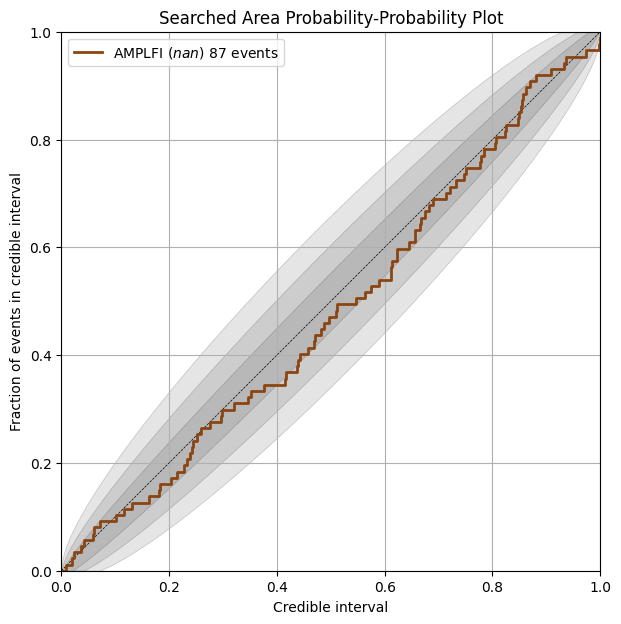

In [10]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="pp_plot")

number_of_samples = len(found)
alphas = [0.68, 0.95, 0.997]
for alpha in alphas:
    ax.add_confidence_band(
        number_of_samples,
        alpha=alpha,
        color=(0, 0, 0, 0.1),
        edgecolor=(0, 0, 0, 0.2),
        annotate=False,
    )
ax.add_diagonal()
p = scipy.stats.kstest(found['aframe_searched_prob'], "uniform").pvalue
ax.add_series(
    found["aframe_searched_prob"],
    label="AMPLFI"
    + r"$~({0:#.2g})$ ".format(round(p, 2))
    + str(len(found))
    + " events",
    color="saddlebrown",
    linewidth=2,
)
"""
p = scipy.stats.kstest(filtered['gstlal_searched_prob'], "uniform").pvalue
ax.add_series(
    filtered["gstlal_searched_prob"],
    label="Gstlal"
    + r"$~({0:#.2g})$ ".format(round(p, 2))
    + str(len(filtered))
    + " events",
    color="blue",
    linewidth=2,
)
"""
plt.title("Searched Area Probability-Probability Plot")
ax.set_xlabel("Credible interval")
ax.set_ylabel("Fraction of events in credible interval")
ax.grid(True)
ax.legend()

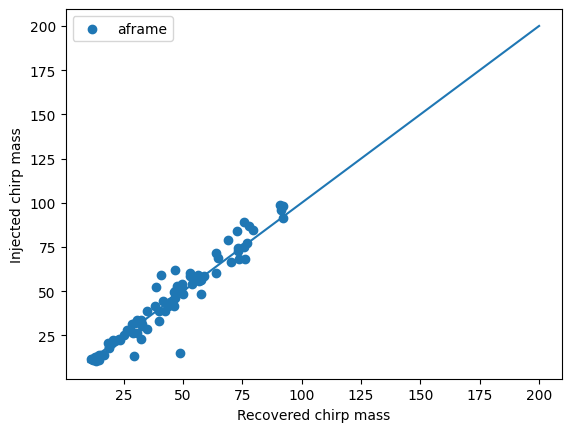

In [60]:
plt.scatter(found["aframe_chirp_mass"], found["chirp_mass"], label="aframe")
#plt.scatter(filtered["gstlal_chirp_mass"], filtered["chirp_mass"], label="gstlal")
plt.xlabel("Recovered chirp mass")
plt.ylabel("Injected chirp mass")
plt.plot([10, 200], [10, 200])
plt.legend()

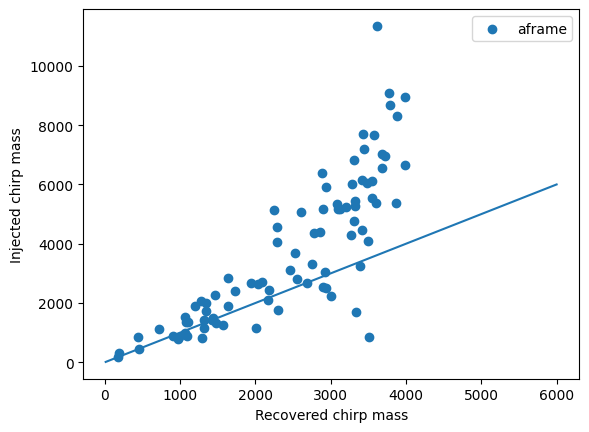

In [59]:
plt.scatter(found["aframe_luminosity_distance"], found["luminosity_distance"], label="aframe")
#plt.scatter(filtered["gstlal_chirp_mass"], filtered["chirp_mass"], label="gstlal")
plt.xlabel("Recovered chirp mass")
plt.ylabel("Injected chirp mass")
plt.plot([10, 6000], [10, 6000])
plt.legend()

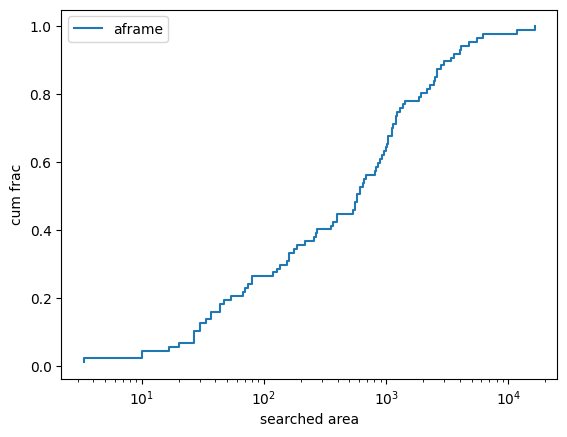

In [58]:
counts = np.arange(1, len(found) + 1) / len(found)
plt.step(np.sort(found["aframe_searched_area"]), counts, label="aframe")
#plt.step(np.sort(filtered["gstlal_searched_area"]), counts, label="gstlal")
plt.xlabel("searched area")
plt.ylabel("cum frac")
plt.legend()
plt.xscale("log")

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          1.,   1.,   1.,   1.,   1.,   0.,   2.,   3., 362.]),
 array([0.00726454, 0.05690131, 0.10653809, 0.15617486, 0.20581163,
        0.25544841, 0.30508518, 0.35472195, 0.40435872, 0.4539955 ,
        0.50363227, 0.55326904, 0.60290582, 0.65254259, 0.70217936,
        0.75181614, 0.80145291, 0.85108968, 0.90072645, 0.95036323,
        1.        ]),
 <BarContainer object of 20 artists>)

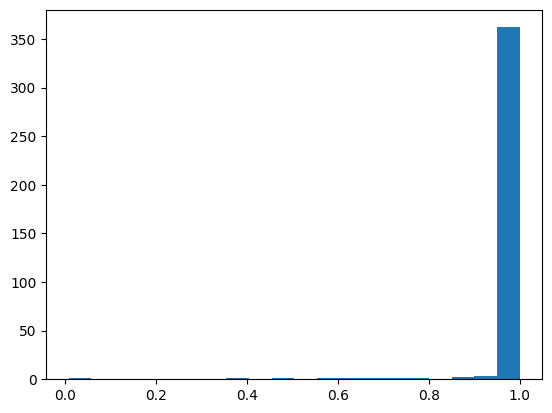

In [ ]:
found = 

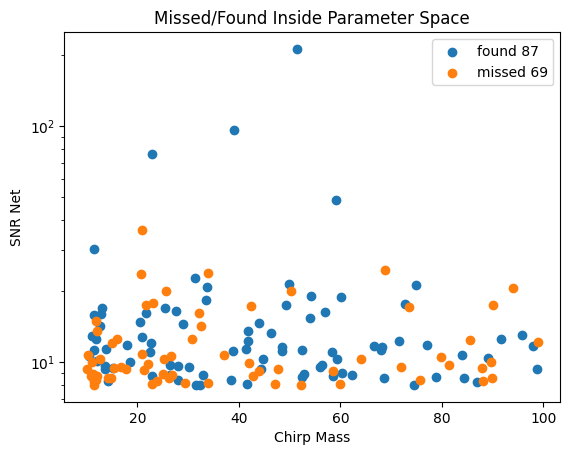

In [56]:
plt.scatter(found["chirp_mass"], found["snr_net"], label=f'found {len(found)}')
plt.scatter(missed["chirp_mass"], missed["snr_net"], label=f'missed {len(missed)}')
plt.xlabel("Chirp Mass")
plt.ylabel("SNR Net")
plt.title("Missed/Found Inside Parameter Space")
plt.yscale("log")
plt.legend()

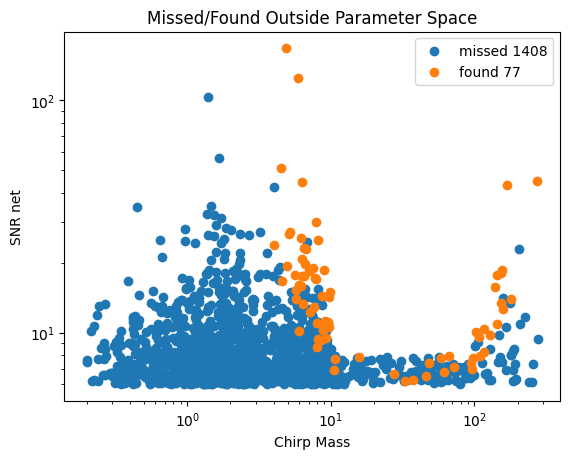

In [57]:

plt.scatter(missed_outside["chirp_mass"], missed_outside["snr_net"], label=f'missed {len(missed_outside)}')
plt.scatter(found_outside["chirp_mass"], found_outside["snr_net"], label=f'found {len(found_outside)}')
plt.title("Missed/Found Outside Parameter Space")
plt.xlabel("Chirp Mass")
plt.ylabel("SNR net")
plt.yscale("log")
plt.xscale('log')
plt.legend()

In [36]:
found.sort_values("snr_net", ascending=False).iloc[0][["time_geocenter_replay", "mass1_detector", "mass2_detector", "snr_net", "observed_snr_H", "observed_snr_L", "H1:DMT-ANALYSIS_READY:1", "L1:DMT-ANALYSIS_READY:1"]]
                                                                                            

time_geocenter_replay      1433702282.203582
mass1_detector                     60.461408
mass2_detector                     57.856021
snr_net                           212.975193
observed_snr_H                    129.836023
observed_snr_L                     155.16652
H1:DMT-ANALYSIS_READY:1                 True
L1:DMT-ANALYSIS_READY:1                 True
Name: 395, dtype: object

In [30]:
missed.columns

Index(['spin1_azimuthal_angle', 'spin1_magnitude', 'spin2z', 'fref',
       'observed_phase_maximized_snr_net', 'time_V', 'spin2_magnitude',
       'phenomxhm_mband_threshold', 'lnpdraw_spin2_azimuthal_angle',
       'right_ascension', 'time_geocenter', 'coa_phase', 'spin2y',
       'observed_phase_maximized_snr_H', 'observed_phase_maximized_snr_V',
       'snr_H', 'spin2_polar_angle', 'inclination', 'lnpdraw_polarization',
       'mass2_source', 'spin1_polar_angle', 'lnpdraw_spin1_azimuthal_angle',
       'lnpdraw_time_geocenter', 'snr_flow', 'observed_snr_V', 'time_H',
       'snr_fhigh', 'mass1_source', 'chi_eff', 'waveform_flow',
       'observed_snr_L', 'q', 'observed_snr_H', 'snr_net',
       'phenomxphm_mband_threshold', 'lnpdraw_right_ascension',
       'lnpdraw_inclination', 'lnpdraw_declination', 'approximant', 'time_L',
       'spin1z',
       'lnpdraw_mass1_source_mass2_source_spin1_magnitude_spin2_magnitude_z',
       'lnpdraw_spin2_polar_angle', 'polarization', 'declinati

## Crossmatch with "offline" mode aframe events

In [2]:
aframe_events = pd.read_hdf("/home/aframe/public_html/o4_llpic_nsbh/event_data.hdf5")
#events = pd.read_hdf("/home/ethan.marx/projects/o4-review/amplfi/mdc_analysis/llpic.hdf5")
events = pd.read_hdf("/home/ethan.marx/projects/mdc-analytics/cycle5.hdf5")
events.time_geocenter_replay = events.time_geocenter

In [3]:
AFRAME_OFFLINE_ATTRS = ["chirp_mass_median", "distance_median", "far", "url"]

def crossmatch_offline_events(
    events: pd.DataFrame,
    pipeline_events: pd.DataFrame,
    dt: float,
) -> tuple[pd.DataFrame, pd.Series]:
    """Crossmatch ground truth events with those found by offline mode
    of Aframe online analysis
    """

    # calculate mask for ground truth events dataframe that 
    # is true if there was a match with any gevent event
    # within dt threshold
    diffs = np.abs(events.time_geocenter_replay.values[:, None] - pipeline_events.gpstime.values[None, :])
    pipeline_args = np.argmin(np.abs(diffs), axis=0) 
    args = np.argmin(np.abs(diffs), axis=1)
    mins = diffs[np.arange(len(diffs)), args]
    mask = mins < dt 

    for attr in AFRAME_OFFLINE_ATTRS:
        output = np.array([None] * len(events))
        output[mask] = pipeline_events.loc[args[mask], f"{attr}"].values 
        events[f"aframe_offline_{attr}"] = output

    # calculate mask for pipeline events dataframe that 
    # is true if there was a match with any mdc event
    # within dt threshold
    diffs = diffs.transpose(1, 0)
    pipeline_mins = diffs[np.arange(len(diffs)), pipeline_args]
    found_mask = pipeline_mins < dt
    
    return events, found_mask

In [4]:
events, found = crossmatch_offline_events(
    events,
    aframe_events,
    0.5
)

In [5]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import multiprocessing as mp
import sys

if 'ipykernel' in sys.modules:
    mp.set_start_method('spawn', force=True)

In [6]:
def parallelize(
    func: callable,
    events: pd.DataFrame,
    max_workers=None,

):
    data = [row for _, row in events.iterrows()]
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(func, data), total=len(data)))
    return results 

In [19]:
func = partial(_process_skymap_offline, kde=False)
results = parallelize(func, events, max_workers=15)
for key in CROSSMATCH_KEYS:
    events[f"aframe_offline_{key}_hist"] = [getattr(result, key) if result else None for result in results]

  0%|          | 0/2364 [00:00<?, ?it/s]

In [ ]:
func = partial(_process_skymap_offline, kde=True)
results = parallelize(func, events, max_workers=5)
for key in CROSSMATCH_KEYS:
    events[f"aframe_offline_{key}_kde"] = [getattr(result, key) if result else None for result in results]

  0%|          | 0/2364 [00:00<?, ?it/s]

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/ethan.marx/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ethan.marx/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python3.10/concurrent/futures/process.py", line 323, in run
    self.terminate_broken(cause)
  File "/home/ethan.marx/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python3.10/concurrent/futures/process.py", line 463, in terminate_broken
    work_item.future.set_exception(bpe)
  File "/home/ethan.marx/.local/share/uv/python/cpython-3.10.17-linux-x86_64-gnu/lib/python3.10/concurrent/futures/_base.py", line 561, in set_exception
    raise InvalidStateError('{}: {!r}'.format(self._state, self))
concurrent.futures._base.InvalidStateError: CANCELLED: <Future at 0x7f9ac01af9a0 state=cancelled>


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

: 

In [ ]:
results.aframe_offline_searched_area_hist

In [20]:
mask = np.logical_and(events.aframe_graceid.values != None, events.aframe_offline_url.values != None)
mask &= events.pycbc_graceid.values != None 
mask &= events.snr_net.values > 10
filtered = events[mask]

In [16]:
filtered

,spin1_azimuthal_angle,spin1_magnitude,spin2z,fref,observed_phase_maximized_snr_net,time_V,spin2_magnitude,phenomxhm_mband_threshold,lnpdraw_spin2_azimuthal_angle,right_ascension,...,aframe_offline_far,aframe_offline_url,aframe_offline_searched_area_hist,aframe_offline_searched_vol_hist,aframe_offline_searched_prob_hist,aframe_offline_searched_prob_vol_hist,aframe_offline_searched_area_kde,aframe_offline_searched_vol_kde,aframe_offline_searched_prob_kde,aframe_offline_searched_prob_vol_kde
40,2.650957,0.078395,0.022167,16.0,19.960760,1.398304e+09,0.224824,0.0,-1.837877,1.533172,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,1.920790,0.318369,0.003919,16.0,13.092932,1.398305e+09,0.227620,0.0,-1.837877,2.075163,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,6.250459,0.013835,0.252284,16.0,16.613771,1.398306e+09,0.360562,0.0,-1.837877,3.474259,...,0.0,/home/aframe/dev/o4_llpic_offline/nsbh/output/...,111.363776,4.532895e+07,0.387136,0.191690,111.363776,4.532895e+07,0.387136,0.191690
58,4.481224,0.868731,-0.962802,16.0,16.711137,1.398309e+09,0.989303,0.0,-1.837877,4.572994,...,0.0,/home/aframe/dev/o4_llpic_offline/nsbh/output/...,2.560501,3.512266e+05,0.026292,0.003520,2.560501,3.512266e+05,0.026292,0.003520
67,4.020089,0.715722,0.387405,16.0,45.312961,1.398311e+09,0.894341,0.0,-1.837877,2.964804,...,0.000107,/home/aframe/dev/o4_llpic_offline/nsbh/output/...,19.159500,2.004066e+09,0.205372,0.999178,19.159500,2.004066e+09,0.205372,0.999178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,2.648397,0.057094,0.158942,16.0,10.513152,1.398895e+09,0.386143,0.0,-1.837877,0.993302,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2351,0.107858,0.682476,0.004829,16.0,21.145651,1.398896e+09,0.295235,0.0,-1.837877,6.139493,...,0.0,/home/aframe/dev/o4_llpic_offline/nsbh/output/...,19.792249,1.633725e+08,0.616573,0.662036,19.792249,1.633725e+08,0.616573,0.662036
2356,4.770953,0.462592,0.032844,16.0,20.427188,1.398897e+09,0.152304,0.0,-1.837877,0.428453,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2360,4.382762,0.482966,-0.036655,16.0,16.645646,1.398898e+09,0.060221,0.0,-1.837877,5.503083,...,0.0,/home/aframe/dev/o4_llpic_offline/nsbh/output/...,13.310673,3.699428e+07,0.046875,0.035913,13.310673,3.699428e+07,0.046875,0.035913


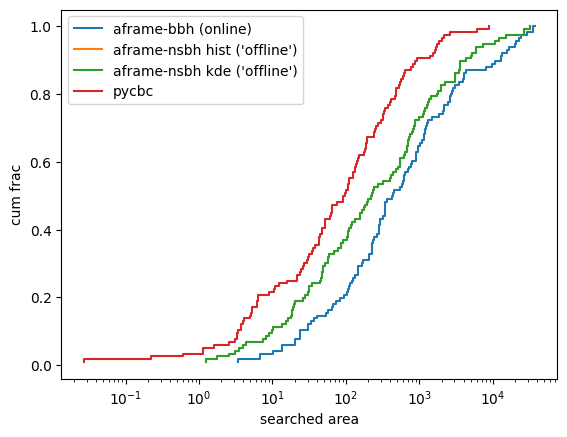

In [21]:
counts = np.arange(1, len(filtered) + 1) / len(filtered)
plt.step(np.sort(filtered["aframe_searched_area"]), counts, label="aframe-bbh (online)")
plt.step(np.sort(filtered["aframe_offline_searched_area_hist"]), counts, label="aframe-nsbh hist ('offline')")
plt.step(np.sort(filtered["aframe_offline_searched_area_kde"]), counts, label="aframe-nsbh kde ('offline')")
plt.step(np.sort(filtered["pycbc_searched_area"]), counts, label="pycbc")
plt.xlabel("searched area")
plt.ylabel("cum frac")
plt.legend()
plt.xscale("log")

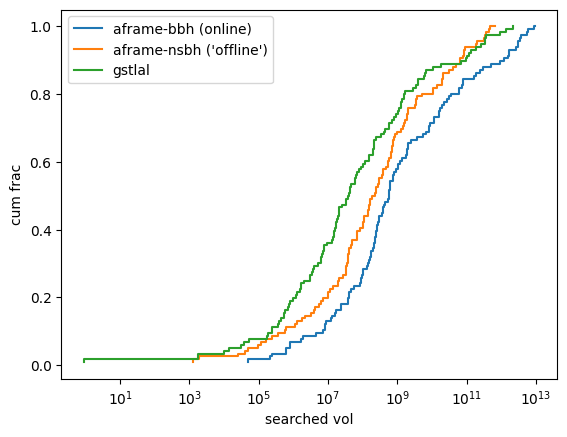

In [54]:
counts = np.arange(1, len(filtered) + 1) / len(filtered)
plt.step(np.sort(filtered["aframe_searched_vol"]), counts, label="aframe-bbh (online)")
plt.step(np.sort(filtered["aframe_offline_searched_vol_hist"]), counts, label="aframe-nsbh hist ('offline')")
plt.step(np.sort(filtered["aframe_offline_searched_vol_kde"]), counts, label="aframe-nsbh kde ('offline')")
plt.step(np.sort(filtered["pycbc_searched_vol"]), counts, label="gstlal")
plt.xlabel("searched vol")
plt.ylabel("cum frac")
plt.legend()
plt.xscale("log")

In [60]:
filtered["pycbc_searched_prob"].isnull().sum()


np.int64(1)

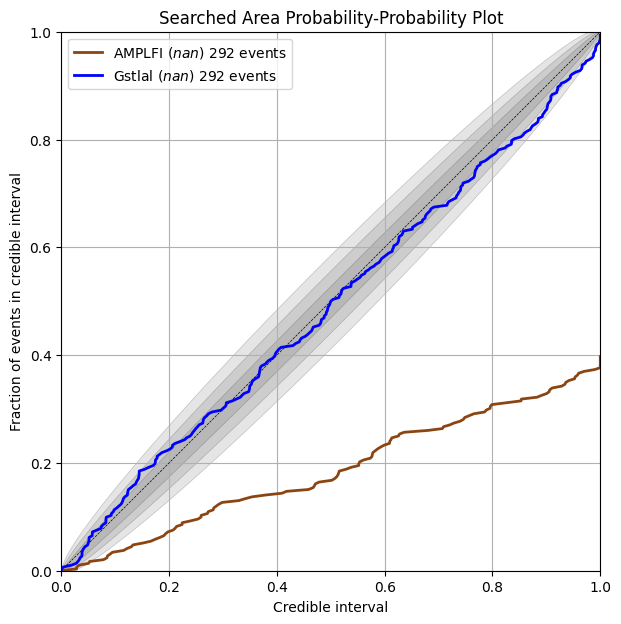

In [66]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="pp_plot")

number_of_samples = len(filtered)
alphas = [0.68, 0.95, 0.997]
for alpha in alphas:
    ax.add_confidence_band(
        number_of_samples,
        alpha=alpha,
        color=(0, 0, 0, 0.1),
        edgecolor=(0, 0, 0, 0.2),
        annotate=False,
    )
ax.add_diagonal()
p = scipy.stats.kstest(filtered['aframe_searched_prob'], "uniform").pvalue
ax.add_series(
    filtered["aframe_searched_prob"],
    label="AMPLFI"
    + r"$~({0:#.2g})$ ".format(round(p, 2))
    + str(len(filtered))
    + " events",
    color="saddlebrown",
    linewidth=2,
)
p = scipy.stats.kstest(filtered['pycbc_searched_prob'], "uniform").pvalue
ax.add_series(
    filtered["pycbc_searched_prob"],
    label="Gstlal"
    + r"$~({0:#.2g})$ ".format(round(p, 2))
    + str(len(filtered))
    + " events",
    color="blue",
    linewidth=2,
)
plt.title("Searched Area Probability-Probability Plot")
ax.set_xlabel("Credible interval")
ax.set_ylabel("Fraction of events in credible interval")
ax.grid(True)
ax.legend()

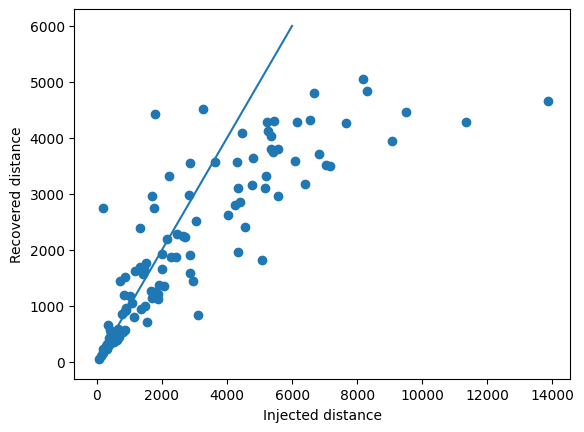

In [84]:
plt.scatter(filtered.luminosity_distance, filtered.aframe_offline_distance_median, label="aframe")
plt.xlabel("Injected distance")
plt.ylabel("Recovered distance")
plt.plot([0, 6e3], [0, 6e3])

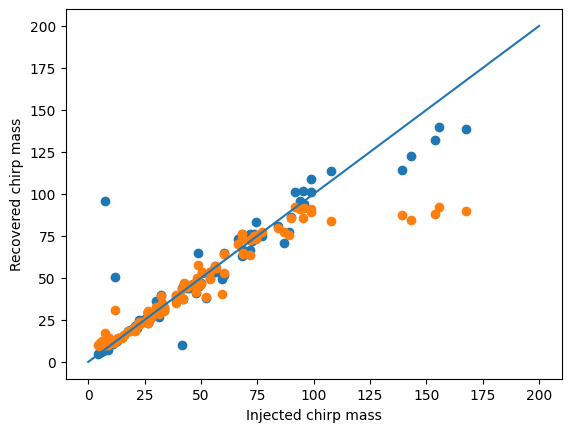

In [86]:
plt.scatter(filtered.chirp_mass, filtered.aframe_offline_chirp_mass_median, label="aframe")
plt.scatter(filtered.chirp_mass, filtered.aframe_chirp_mass, label="aframe-online")
plt.xlabel("Injected chirp mass")
plt.ylabel("Recovered chirp mass")
plt.plot([0, 200], [0, 200])


In [61]:
events.aframe_chirp_mass

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2359   NaN
2360   NaN
2361   NaN
2362   NaN
2363   NaN
Name: aframe_chirp_mass, Length: 2364, dtype: float64

In [20]:
bayestar_ifo_configs = [{"H1"}, frozenset(["H1", "L1"])]

In [17]:
bayestar_ifo_configs[1] == {"L1", "H1"}

True

In [21]:
results = {}
results[bayestar_ifo_configs[1]] = 5

In [22]:
frozenset(["H1", "L1"]) - frozenset(["H1"])

frozenset({'L1'})

In [27]:
"".join([x[0] for x in sorted(frozenset(["H1", "L1"]))])

'HL'

In [28]:
frozenset(["H1"]) - frozenset(["H1", "L1"])

frozenset()